# 📘 Урок: Работа в DWH через Python

## SQLAlchemy

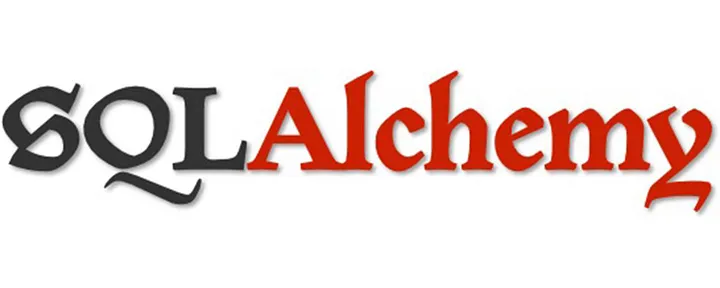

В реальных компаниях, как правило, Data Scientist коннектится к DWH с помощью **SQLAlchemy** — единый коннектор к любой SQL-базе:

* PostgreSQL
* MySQL
* Snowflake
* Redshift
* BigQuery (через драйвер)
* SQLite (в нашем случае используем его)

и др.

SQLAlchemy решает задачу **унифицированного доступа**:

- один API -> множество разных DWH

- удобно использовать в Jupyter

- позволяет писать SQL прямо в ноутбуке

- управляет подключениями

- поддерживает и ORM, и обычные SQL-запросы




##  Почему в качестве БД использована SQLite?

Потому что:

* SQLite легко создать локально
* не требует сервера
* хорошо подходит для учебных задач
* красиво демонстрирует все SQL-приёмы

Но важно понимать:

> В реальной работе вместо SQLite будет **настоящее DWH**, а SQLAlchemy остаётся тем же.

Подключение к базе

In [1]:
import os
import requests
import pandas as pd
from sqlalchemy import create_engine

# URL к базе
url = "https://raw.githubusercontent.com/totiela/stepik_simulator_ds/main/lessons/lesson_3_2/dwh_base.db"
local_path = "dwh_base.db"

# Скачиваем файл, если его нет
if not os.path.exists(local_path):
    r = requests.get(url)
    r.raise_for_status()
    with open(local_path, "wb") as f:
        f.write(r.content)

# Подключение через SQLAlchemy
engine = create_engine(f"sqlite:///{local_path}")

In [3]:
# Проверяем: выводим список таблиц
pd.read_sql('''SELECT name 
            FROM sqlite_master 
            WHERE type='table';''', engine)

,name
0,src__customers_raw
1,src__accounts_raw
2,src__transactions_raw
3,src__events_raw
4,stg__customers
5,stg__accounts
6,stg__transactions
7,stg__events
8,dwh__dim_customer
9,dwh__dim_account


## Описание данных

### 🟦 1. Source Layer (SRC RAW) — *сырые данные как из CRM/логов*

Это **оригинальные данные**, которые обычно приходят:

* из CRM,
* из API,
* из логов мобильного/веб-приложения,
* из кассовых систем,
* из CSV/Excel файлов.

В них могут быть ошибки, пропуски, странные форматы.

### Таблицы:

| Таблица                     | Что хранит                     | Почему сырое?                                                        |
| --------------------------- | ------------------------------ | -------------------------------------------------------------------- |
| **`src__customers_raw`**    | Имена, телефоны, даты рождения | Разные форматы дат, VIP-флаг как `yes/no/Y/N`, возможны пропуски     |
| **`src__accounts_raw`**     | Счета клиентов                 | Балансы могут быть отрицательные, статусы — нестандартные            |
| **`src__transactions_raw`** | Транзакции                     | Суммы могут быть отрицательные/ошибочные, нет нормального ID клиента |
| **`src__events_raw`**       | Логи действий                  | Много шума, повторов, нет нормальной типизации                       |

In [6]:
pd.read_sql('''SELECT * 
            FROM src__customers_raw 
            LIMIT 10;''', engine)

,CustomerID,FullName,BirthDate,Phone,is_vip_flag,SignUpChannel
0,1,Алексей Сидоров,None,None,1,kiosk
1,2,Алексей Кузнецов,None,+74537325166,0,web
2,3,МАРИЯ Иванов,2000-11-8,+74537325166,1,??
3,4,Сергей Петров,2000-11-8,87118618511,no,??
4,5,Алексей Кузнецов,2000-11-8,+74537325166,None,kiosk
5,6,Мария Петров,2000-11-8,+74537325166,Y,branch
6,7,Иван Сидоров,2000-11-8,87118618511,0,??
7,8,МАРИЯ Иванов,2000-11-8,+74537325166,no,??
8,9,Анна Иванов,2000-11-8,+74537325166,yes,MOBILE
9,10,МАРИЯ Кузнецов,2000-11-8,+74537325166,1,MOBILE


### 🟧 2. Staging Layer (STG) — *приведённые в порядок данные*

STG — это слой, где сырые данные проходят первичную очистку и нормализацию, чтобы их можно было безопасно использовать дальше.

Это НЕ аналитическая модель, но это уже данные, с которыми:

* не «ломается» преобразование типов,
* корректно работают JOIN’ы,
* можно считать агрегаты,
* можно строить витрины.

По сути, STG — это **буфер между хаосом RAW и структурой DWH**.

### Таблицы:

| Таблица                 | Что изменили                                                                 |
| ----------------------- | ---------------------------------------------------------------------------- |
| **`stg__customers`**    | Стандартизировали имена колонок, преобразовали `vip_flag`, даты — в datetime |
| **`stg__accounts`**     | Привели типы, стандартизировали тип счета                                    |
| **`stg__transactions`** | Чистый timestamp, правильные названия колонок                                |
| **`stg__events`**       | Привели формат времени и типы событий                                        |

In [7]:
pd.read_sql('''SELECT * 
            FROM stg__customers 
            LIMIT 10;''', engine)

,customer_id,full_name,birth_date_raw,phone_raw,vip_flag_raw,signup_channel_raw,birth_date,phone,vip_flag,signup_channel
0,1,Алексей Сидоров,None,None,1,kiosk,None,None,1.0,kiosk
1,2,Алексей Кузнецов,None,+74537325166,0,web,None,+74537325166,0.0,web
2,3,Мария Иванов,2000-11-8,+74537325166,1,??,2000-11-08 00:00:00,+74537325166,1.0,unknown
3,4,Сергей Петров,2000-11-8,87118618511,no,??,2000-11-08 00:00:00,+77118618511,0.0,unknown
4,5,Алексей Кузнецов,2000-11-8,+74537325166,None,kiosk,2000-11-08 00:00:00,+74537325166,NaN,kiosk
5,6,Мария Петров,2000-11-8,+74537325166,Y,branch,2000-11-08 00:00:00,+74537325166,1.0,branch
6,7,Иван Сидоров,2000-11-8,87118618511,0,??,2000-11-08 00:00:00,+77118618511,0.0,unknown
7,8,Мария Иванов,2000-11-8,+74537325166,no,??,2000-11-08 00:00:00,+74537325166,0.0,unknown
8,9,Анна Иванов,2000-11-8,+74537325166,yes,MOBILE,2000-11-08 00:00:00,+74537325166,1.0,mobile
9,10,Мария Кузнецов,2000-11-8,+74537325166,1,MOBILE,2000-11-08 00:00:00,+74537325166,1.0,mobile


### 🟩 3. DWH Layer (ядро хранилища)

Это **сердце хранилища**, где данные превращаются в:


Справочники и «понятия»

| Таблица                 | Описание                                                               |
| ----------------------- | ---------------------------------------------------------------------- |
| **`dwh__dim_customer`** | Измерение клиента: ФИО, телефон, дата рождения, единообразный VIP-флаг |
| **`dwh__dim_account`**  | Измерение счёта: тип, дата открытия, клиент                            |


События, которые можно считать, суммировать.

| Таблица                      | Описание                             |
| ---------------------------- | ------------------------------------ |
| **`dwh__fact_transactions`** | Все транзакции, привязанные к счетам |
| **`dwh__fact_events`**       | Все действия клиентов в приложении   |

In [9]:
pd.read_sql('''SELECT * 
            FROM dwh__fact_transactions 
            LIMIT 10;''', engine)

,txn_id,account_id_raw,amount_raw,txn_time_raw,category,account_id,amount,txn_time,account_sk
0,1,1270,-4667.351889058535,2022-06-02 00:00:00,transfer,1270,-4667.351889,2022-02-06 00:00:00,1270
1,2,1104,-3658.987033452697,2020-06-17 00:00:00,atm,1104,-3658.987033,None,1104
2,3,885,9018.893674267936,2022-12-01 00:00:00,transfer,885,9018.893674,2022-01-12 00:00:00,885
3,4,487,12313.175747350408,18-12-2022 00:00:00,transfer,487,12313.175747,None,487
4,5,43,-12716.22190934183,23-08-2021 00:00:00,atm,43,-12716.221909,None,43
5,6,1034,-9446.912548095892,08-06-2021 00:00:00,purchase,1034,-9446.912548,None,1034
6,7,194,10603.223391341726,2021-01-29 00:00:00,atm,194,10603.223391,None,194
7,8,523,-11689.612044206395,15-05-2022 00:00:00,income,523,-11689.612044,None,523
8,9,1419,14135.375501671217,04-06-2022 00:00:00,atm,1419,14135.375502,None,1419
9,10,159,-18069.838749896706,2023-04-04 00:00:00,income,159,-18069.838750,2023-04-04 00:00:00,159


In [8]:
pd.read_sql('''SELECT 
            customer_id, 
            COUNT(*) 
            FROM dwh__fact_events 
            GROUP BY 1 
            LIMIT 10;''', engine)

,customer_id,COUNT(*)
0,1,7
1,2,13
2,3,11
3,4,6
4,5,4
5,6,10
6,7,11
7,8,11
8,9,10
9,10,7


### 🟨 4. Consumption Layer (MARTS)* — витрины которые уже создал Data Scientist

Это слой, на котором появляются **готовые фичи**:

* агрегаты,
* суммы,
* окна,
* поведенческие признаки.

| Таблица                     | Описание                                                           |
| --------------------------- | ------------------------------------------------------------------ |
| **`mrt__account_features`** | Суммы, средние, мин/макс транзакций по каждому счёту — готово к ML |


In [10]:
pd.read_sql('''SELECT * 
            FROM mrt__account_features 
            LIMIT 10;''', engine)

,account_id,amount_sum,amount_mean,amount_max,amount_min,amount_count,txn_count
0,1,-34960.110585,-3496.011058,17681.940889,-14193.210897,10,10
1,2,2964.060702,296.406070,17896.574437,-19250.423854,10,10
2,3,41305.750727,5163.218841,18803.352062,-13766.010316,8,8
3,4,-10995.389167,-1221.709907,14240.580558,-13679.080492,9,9
4,5,28529.602838,4075.657548,19345.191921,-1836.973405,7,7
5,6,-25489.810152,-4248.301692,8124.919729,-18737.709039,6,6
6,7,-25231.951154,-5046.390231,16866.253276,-17903.736200,5,5
7,8,-49569.694603,-16523.231534,-10068.203112,-19985.907154,3,3
8,9,37360.582589,4151.175843,18392.459047,-10499.725634,9,9
9,10,-27197.778870,-2719.777887,19333.276455,-19559.587470,10,10


### Работа с DWH

In [11]:
# Сколько событий на каждого клиента?
pd.read_sql("""
SELECT customer_id, COUNT(*) AS events
FROM dwh__fact_events
GROUP BY 1
ORDER BY events DESC
LIMIT 5;
""", engine)


,customer_id,events
0,471,20
1,931,19
2,526,18
3,524,18
4,409,18


In [12]:
# Выявление счетов с ночной активностью - может быть полезно для модели антифрода
pd.read_sql("""
SELECT
    t.account_id,
    COUNT(*) AS night_txn
FROM dwh__fact_transactions t
WHERE CAST(STRFTIME('%H', t.txn_time) AS INTEGER) BETWEEN 0 AND 5
GROUP BY t.account_id;

""", engine)

,account_id,night_txn
0,1,2
1,2,4
2,3,2
3,4,4
4,5,1
...,...,...
788,1486,1
789,1487,1
790,1489,1
791,1490,2


In [13]:
# Средний баланс по типам счетов
pd.read_sql("""
SELECT acc_type, AVG(balance) AS avg_balance
FROM dwh__dim_account
GROUP BY acc_type;
""", engine)


,acc_type,avg_balance
0,credit,144895.408853
1,debit,144978.041239
2,unknown,142036.518982


In [14]:
# готовый набор признаков: баланс, транзакции, активность, поведение
df_features = pd.read_sql("""
SELECT
    a.customer_id,
    SUM(f.amount_sum) AS total_spent,
    SUM(f.txn_count) AS total_txn,
    AVG(a.balance) AS avg_balance,
    c.vip_flag,
    c.signup_channel,
    COUNT(e.event_id) AS event_count
FROM dwh__dim_customer c
LEFT JOIN dwh__dim_account a ON c.customer_id = a.customer_id
LEFT JOIN mrt__account_features f ON a.account_id = f.account_id
LEFT JOIN dwh__fact_events e ON c.customer_id = e.customer_id
GROUP BY c.customer_id;
""", engine)

df_features.head()


,customer_id,total_spent,total_txn,avg_balance,vip_flag,signup_channel,event_count
0,1.0,115165.674838,56.0,70712.470308,1.0,kiosk,14
1,2.0,5610.377747,13.0,17065.533361,0.0,web,13
2,NaN,NaN,NaN,NaN,1.0,unknown,11
3,4.0,-61622.351540,66.0,71777.529971,0.0,unknown,24
4,5.0,40384.790570,16.0,173862.933718,NaN,kiosk,4


** в зависимости от того что мы хотим предсказывать, здесь может быть утечка данных, об этом поговорим позже!

### Самостоятельное задание

1. Посчитать клиентов, у которых больше 3х активных счетов

P.S. Активным является любой счет в `dwh__dim_account`

In [21]:
pd.read_sql("""
SELECT COUNT(*) AS customers_with_many_accounts
FROM (
    SELECT customer_id
    FROM dwh__dim_account
    GROUP BY customer_id
    HAVING COUNT(*) > 3
);
""", engine)

,customers_with_many_accounts
0,71


Вопрос 1: Сколько клиентов имеют более 3 активных счетов?

 -> ответ внести в Stepik

2. Посчитать количество транзакций по типам (`debit` / `credit`)**
Транзакции лежат в `dwh__fact_transactions`, а тип счёта — в `dwh__dim_account`.

In [ ]:
pd.read_sql("""
SELECT a.acc_type,
COUNT(*) AS acc_type_cnt
FROM dwh__fact_transactions t
INNER JOIN dwh__dim_account a
ON t.account_id_raw = a.account_id
WHERE a.acc_type = 'debit'
GROUP BY a.acc_type;
""", engine)

,acc_type,acc_type_cnt
0,debit,2002


Вопрос 2: какое количество транзакций у счетов типа `debit`?

 -> ответ внести в Stepik

3. Посичтать сколько клиентов (*customer_id*) совершили больше 15 событий (`dwh__fact_events`) и более 5 транзакций (`dwh__fact_transactions`)?

In [56]:
print('dwh__dim_customer')
display(pd.read_sql("""
SELECT * FROM dwh__dim_customer
LIMIT 5;
""", engine))

print('dwh__fact_events')
display(pd.read_sql("""
SELECT * FROM dwh__fact_events
LIMIT 5;
""", engine))

print('dwh__dim_account')
display(pd.read_sql("""
SELECT * FROM dwh__dim_account
LIMIT 5;
""", engine))

print('dwh__fact_transactions')
pd.read_sql("""
SELECT * FROM dwh__fact_transactions
LIMIT 5;
""", engine)

dwh__dim_customer


,customer_sk,customer_id,full_name,birth_date,phone,vip_flag,signup_channel,effective_from,effective_to
0,1,1,Алексей Сидоров,None,None,1.0,kiosk,2025-12-07 11:54:36.351152,None
1,2,2,Алексей Кузнецов,None,+74537325166,0.0,web,2025-12-07 11:54:36.351152,None
2,3,3,Мария Иванов,2000-11-08 00:00:00,+74537325166,1.0,unknown,2025-12-07 11:54:36.351152,None
3,4,4,Сергей Петров,2000-11-08 00:00:00,+77118618511,0.0,unknown,2025-12-07 11:54:36.351152,None
4,5,5,Алексей Кузнецов,2000-11-08 00:00:00,+74537325166,NaN,kiosk,2025-12-07 11:54:36.351152,None


dwh__fact_events


,event_id,customer_id,event_type_raw,event_time_raw,device,event_type,event_time,customer_sk
0,1,891,login,2022-01-11 00:00:00,unknown,login,2022-11-01 00:00:00,891
1,2,946,login,2022-01-11 00:00:00,android,login,2022-11-01 00:00:00,946
2,3,199,screen_view,None,unknown,screen_view,None,199
3,4,397,None,29/09/2023 00:00,android,None,None,397
4,5,407,None,None,android,None,None,407


dwh__dim_account


,account_sk,account_id,customer_id,opened_dt,acc_type,balance,effective_from,effective_to
0,1,1,266,2018-03-09 00:00:00,debit,98852.157799,2025-12-07 11:54:36.420976,None
1,2,2,676,None,unknown,214779.427381,2025-12-07 11:54:36.420976,None
2,3,3,977,None,credit,20231.979471,2025-12-07 11:54:36.420976,None
3,4,4,855,None,credit,8303.262937,2025-12-07 11:54:36.420976,None
4,5,5,775,None,debit,181733.064632,2025-12-07 11:54:36.420976,None


dwh__fact_transactions


,txn_id,account_id_raw,amount_raw,txn_time_raw,category,account_id,amount,txn_time,account_sk
0,1,1270,-4667.351889058535,2022-06-02 00:00:00,transfer,1270,-4667.351889,2022-02-06 00:00:00,1270
1,2,1104,-3658.987033452697,2020-06-17 00:00:00,atm,1104,-3658.987033,None,1104
2,3,885,9018.893674267936,2022-12-01 00:00:00,transfer,885,9018.893674,2022-01-12 00:00:00,885
3,4,487,12313.175747350408,18-12-2022 00:00:00,transfer,487,12313.175747,None,487
4,5,43,-12716.22190934183,23-08-2021 00:00:00,atm,43,-12716.221909,None,43


In [54]:
pd.read_sql("""
SELECT e.customer_id,
COUNT(e.event_id) AS event_cnt,
COUNT(t.txn_id) AS txn_cnt
FROM dwh__fact_transactions t
JOIN dwh__fact_events e
ON t.account_id = e.customer_id
GROUP BY e.customer_id
LIMIT 5;
""", engine)

,customer_id,event_cnt,txn_cnt
0,1,70,70
1,2,130,130
2,3,88,88
3,4,54,54
4,5,28,28


Вопрос 3: Сколько клиентов совершили больше 15 событий (dwh__fact_events) и более 5 транзакций (dwh__fact_transactions)?

 -> ответ внести в Stepik